In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import celestializer as cl
import matplotlib.pyplot as plt

In [2]:
img_sky = cl.RawImage(cl.Paths.observations / "2024-11-05/IMG_3320.CR2").load()
img = img_sky.raw().green_interpolated()
img_sky.metadata.model_dump()

{'width': 5202,
 'height': 3465,
 'focal_length': 18.0,
 'aperture': 3.5,
 'shutter': 10.0,
 'iso': 6400,
 'timestamp': datetime.datetime(2024, 11, 5, 0, 37, 58),
 'camera': 'Canon EOS 1200D',
 'bit_depth': 14}

In [3]:
img_in = img.green_interpolated()
img_in = cl.correct_vignette(img_in)
img_in = img_in.channel("green")

mask_hot, mask_dead = cl.find_defects(img_in)
print(f"Found {mask_hot.sum()} hot pixels and {mask_dead.sum()} dead pixels")
mask = mask_hot | mask_dead
img_in = cl.replace_defects(img_in, mask)
img_in = img_in.green_interpolated()
img_in -= img_in.min()
img_in /= img_in.max()

Found 42 hot pixels and 107 dead pixels


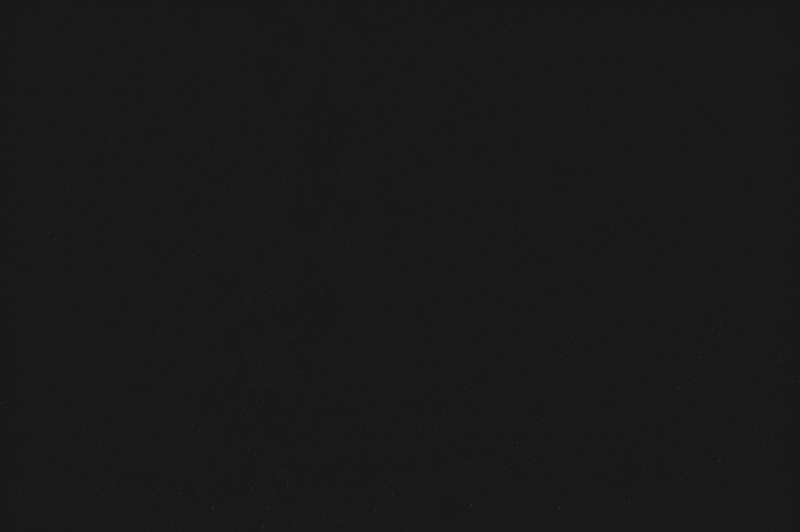

In [4]:
import numpy as np
from numpy.typing import NDArray

def fill_mask(img: cl.ImageNBit, mask: NDArray[np.bool], color: float | None = None) -> cl.ImageNBit:
    if color is None:
        # Get most common color in img
        color_space = np.linspace(0, img.bit_depth, 256)
        (hist, _) = np.histogram(img[~mask], bins=color_space)
        color = color_space[np.argmax(hist)]

    # Fill mask with color
    img_filled = img.copy()
    img_filled[mask] = color
    return cl.ImageNBit(img_filled, img.bit_depth)

mask = cl.classify_star_pixels(img_in.to_bitdepth(8))
img_no_stars = fill_mask(img_in, mask)
img_no_stars.save(cl.Paths.saved / "sky_without_stars.png")
img_no_stars.preview().show()

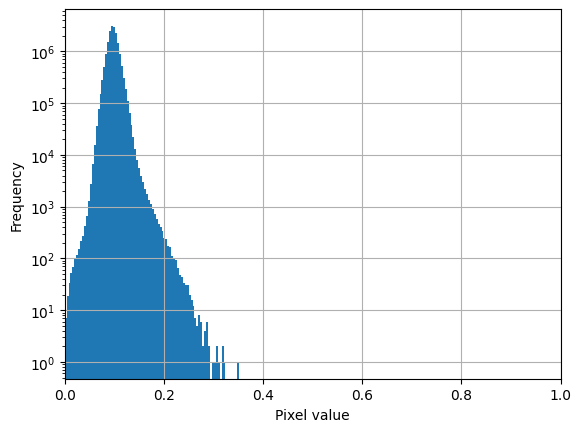

In [14]:
# Plot histogram of pixel values
plt.figure()
plt.hist(img_no_stars.flatten(), bins=256, range=(0, 1))
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.xlim(0, 1)
plt.grid()
plt.savefig(cl.Paths.saved / "histogram_without_stars.png", dpi=300, bbox_inches="tight")
plt.show()

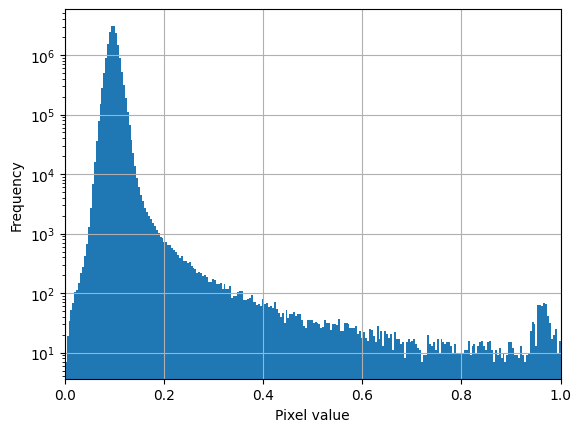

In [13]:
# Plot histogram of original pixel values for comparison
plt.figure()
plt.hist(img_in.flatten(), bins=256, range=(0, 1))
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.xlim(0, 1)
plt.grid()
plt.savefig(cl.Paths.saved / "histogram_preprocessed.png", dpi=300, bbox_inches="tight")
plt.show()